In [2]:
import os 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
import zipfile
from sklearn.model_selection import train_test_split

In [4]:
os.environ["KAGGLE_USERNAME"]="daominhkhanh"
os.environ["KAGGLE_KEY"]="90e6f266906e9dcfeae1afea9a0630ac"
!kaggle competitions download -c airbnb-recruiting-new-user-bookings

  0% 0.00/478k [00:00<?, ?B/s]
100% 478k/478k [00:00<00:00, 66.4MB/s]
100% 59.0M/59.1M [00:00<00:00, 54.4MB/s]
100% 59.1M/59.1M [00:00<00:00, 86.7MB/s]
  0% 0.00/546 [00:00<?, ?B/s]
100% 546/546 [00:00<00:00, 465kB/s]
  0% 0.00/2.46k [00:00<?, ?B/s]
100% 2.46k/2.46k [00:00<00:00, 2.40MB/s]
  0% 0.00/4.07M [00:00<?, ?B/s]
100% 4.07M/4.07M [00:00<00:00, 66.3MB/s]
  0% 0.00/1.03M [00:00<?, ?B/s]
100% 1.03M/1.03M [00:00<00:00, 144MB/s]


In [5]:
for file in os.listdir(os.getcwd()):
  if "zip" in file:
    with zipfile.ZipFile(file,'r') as zip:
      zip.extractall()

In [6]:
!rm *.zip

##  Đọc dữ liệu 

In [78]:
train=pd.read_csv('train_users_2.csv')
test=pd.read_csv('test_users.csv')
age_gender=pd.read_csv('age_gender_bkts.csv')
countries=pd.read_csv('countries.csv')
sessions=pd.read_csv('sessions.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


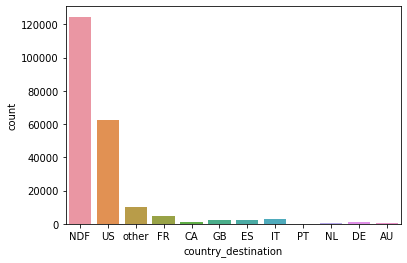

In [79]:
sns.countplot(train.country_destination)

#  Hiện thị các cột có thông  tin bị Nan   

In [80]:
def show_nan(dataframe):
  for name_columns in dataframe.keys():
    if dataframe[name_columns].isnull().values.any():
      print(name_columns,':',dataframe[name_columns].isna().sum())
 

In [81]:
show_nan(train)

date_first_booking : 124543
age : 87990
first_affiliate_tracked : 6065


In [82]:
show_nan(test)

date_first_booking : 62096
age : 28876
first_affiliate_tracked : 20


# 1  Tiền xử  lý dữ  liệu

In [83]:
users=pd.concat((train,test),axis=0)

In [84]:
print(users.shape)
print(train.shape)
print(test.shape)

(275547, 16)
(213451, 16)
(62096, 15)


In [85]:
users.drop(['id','date_first_booking'],axis=1,inplace=True)

In [86]:
print(set(users.gender))

{'MALE', '-unknown-', 'OTHER', 'FEMALE'}


Thay giới tính --unknown- = OTHER 

In [87]:
users.gender=users.gender.replace('OTHER','-unknown-')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


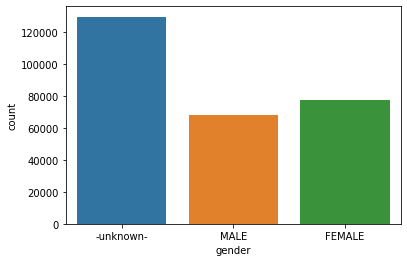

In [88]:
sns.countplot(users.gender)

In [89]:
def cal_avg_age(dataframe):
  temp=np.array(dataframe.age.isnull())
  age_not_nan=np.where(temp==False)[0]
  ages=np.array(dataframe.age)
  ages=ages[age_not_nan]
  avg_age=np.sum(ages)/len(ages)
  return int(round(avg_age))

Xử lý các dữ liệu bị sai tuổi 

In [90]:
ages=users.age.values
users.age=np.where(np.logical_and(ages>1900, ages<2015),2015-ages,ages)

In [91]:
users.loc[(users.age>115) | (users.age<5),'age']=np.nan

In [92]:
show_nan(users)

age : 117631
first_affiliate_tracked : 6085
country_destination : 62096


Do trường thuộc tinh first_affiliate_tracked=nan nên ta sẽ xử lý những giá trị này bằng cách thay bằng giá trị mode của first_affiliate_tracked

In [93]:
mode_first_affilicate_value=users.first_affiliate_tracked.mode().iat[0]
users.first_affiliate_tracked=users.first_affiliate_tracked.fillna(mode_first_affilicate_value)

In [94]:
show_nan(users)

age : 117631
country_destination : 62096


Vì trong một năm thì mùa du lịch sẽ chỉ tập trung ở những tháng cố định nên các năm khác nhau thì sẽ có điểm chung là mùa du lịch tập trung vào 
các tháng cố định nên ta sẽ thay các trường thuộc tính như date_account_created, timestamp_first_active bằng giá trị tháng

In [95]:
from sklearn.preprocessing import OrdinalEncoder
def preprocessing_data(dataframe):
  date_account_create=np.vstack(dataframe.date_account_created.astype(str).apply(lambda x: list (map(int,x.split('-')))).values)
  dataframe['dac_month']=date_account_create[:,1]
  dataframe.drop(['date_account_created'],axis=1,inplace=True)
  timetamp_first_active=np.vstack(dataframe.timestamp_first_active.astype(str).apply(lambda x:list(map(int,[x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
  dataframe['tfa_month']=timetamp_first_active[:,1]
  dataframe.drop(['timestamp_first_active'],axis=1,inplace=True)
  return dataframe


In [96]:
users=preprocessing_data(users)

In [97]:
train1=users.copy()#replace nan age=avg_age
train2=users.copy()#replace nan age = algorithm knn

#  Xử lý trường age
- Thay các giá trị age bị nan bằng giá trị age trung bình 
- Dùng KNN Regression để tìm kiếm các giá trị age nan 

1)  Thay bằng giá trị trung bình

In [98]:
def cal_avg_age(dataframe):
  temp=np.array(dataframe.age.isnull())
  age_not_nan=np.where(temp==False)[0]
  ages=np.array(dataframe.age)
  ages=ages[age_not_nan]
  avg_age=np.sum(ages)/len(ages)
  return int(round(avg_age))

In [99]:
avg_age=cal_avg_age(train1)
train1.age=train1.age.fillna(avg_age)

In [100]:
features=['gender','signup_method','signup_flow','language','affiliate_channel','affiliate_provider','first_affiliate_tracked','signup_app','first_device_type','first_browser']

In [101]:
for feature in features:
  ord_encoder=OrdinalEncoder()
  train1[feature]=ord_encoder.fit_transform(train1[[feature]])

In [103]:
train_avg=train1[:len(train)]
test_avg=train1[len(train):]
test_avg.drop('country_destination',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [104]:
list_label=set(train_avg.country_destination)
t={country:idx for idx,country in enumerate(list_label)}

In [105]:
t

{'AU': 10,
 'CA': 3,
 'DE': 2,
 'ES': 11,
 'FR': 5,
 'GB': 1,
 'IT': 9,
 'NDF': 4,
 'NL': 7,
 'PT': 6,
 'US': 0,
 'other': 8}

In [106]:
train_avg.country_destination=train_avg.country_destination.map(t)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [107]:
train_avg

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,dac_month,tfa_month
0,0.0,37.0,1.0,0.0,6.0,2.0,4.0,6.0,2.0,3.0,8.0,4,6,3
1,2.0,38.0,1.0,0.0,6.0,7.0,8.0,6.0,2.0,3.0,8.0,4,5,5
2,1.0,56.0,0.0,3.0,6.0,2.0,4.0,6.0,2.0,6.0,22.0,0,9,6
3,1.0,42.0,1.0,0.0,6.0,2.0,4.0,6.0,2.0,3.0,17.0,8,12,10
4,0.0,41.0,0.0,0.0,6.0,2.0,4.0,6.0,2.0,3.0,8.0,0,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,2.0,32.0,0.0,0.0,6.0,5.0,8.0,3.0,2.0,3.0,43.0,4,6,6
213447,0.0,37.0,0.0,0.0,6.0,2.0,4.0,0.0,2.0,6.0,8.0,4,6,6
213448,0.0,32.0,0.0,0.0,6.0,2.0,4.0,6.0,2.0,3.0,17.0,4,6,6
213449,0.0,37.0,0.0,17.0,6.0,3.0,12.0,5.0,3.0,8.0,30.0,4,6,6


In [108]:
def split_file(data_frame):
  size=len(data_frame)
  train_dataframe=data_frame.sample(int(size*0.8))
  val_dataframe=data_frame[~data_frame.index.isin(train_dataframe.index)]
  return train_dataframe,val_dataframe

In [109]:
train_avg1=train_avg.sort_index(axis=1)
test_avg=test_avg.sort_index(axis=1)
train_avg,val_avg=split_file(train_avg1)

In [110]:
print(train_avg1.shape)
print(train_avg.shape)
print(val_avg.shape)

(213451, 14)
(170760, 14)
(42691, 14)


In [111]:
train_avg.to_csv('train_avg_age.csv',index=False)
val_avg.to_csv('val_avg_age.csv',index=False)
test_avg.to_csv('test_avg_age.csv',index=False)

2) Dùng KNN Regression để tìm kiếm các giá trị age nan 

In [112]:
# Chuyển  sang one-hot 
def processing_train2(dataframe):
  for feature in features:
    df_dummy=pd.get_dummies(dataframe[feature],prefix=feature)
    dataframe=dataframe.drop(feature,axis=1)
    dataframe=pd.concat((dataframe,df_dummy),axis=1)
  return dataframe

train2=processing_train2(train2)

In [113]:
train2.age=train2.age.fillna(-1)
country=train2.country_destination
train2.drop('country_destination',axis=1,inplace=True)
train_age=train2[train2.age!=-1]
test_age=train2[train2.age==-1]

y_train_age=np.asarray(train_age.age)
x_train_age=train_age.drop('age',axis=1)

x_test_age=test_age.drop('age',axis=1)

x_train_age=x_train_age.values
x_test_age=x_test_age.values

In [114]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train_age,y_train_age)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [115]:
y_pred=knn.predict(x_test_age)

In [116]:
y_pred=[int(round(value)) for value in y_pred]

In [117]:
drop_column=list(train2.keys())[3:]
train2=train2.drop(drop_column,axis=1)
train2['country_destination']=country

In [118]:
for feature in features:
 train2[feature]=train1[feature]

In [120]:
train2

,age,dac_month,tfa_month,country_destination,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,-1.0,6,3,NDF,0.0,1.0,0.0,6.0,2.0,4.0,6.0,2.0,3.0,8.0
1,38.0,5,5,NDF,2.0,1.0,0.0,6.0,7.0,8.0,6.0,2.0,3.0,8.0
2,56.0,9,6,US,1.0,0.0,3.0,6.0,2.0,4.0,6.0,2.0,6.0,22.0
3,42.0,12,10,other,1.0,1.0,0.0,6.0,2.0,4.0,6.0,2.0,3.0,17.0
4,41.0,9,12,US,0.0,0.0,0.0,6.0,2.0,4.0,6.0,2.0,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,31.0,9,9,NaN,0.0,0.0,0.0,6.0,2.0,4.0,6.0,2.0,6.0,22.0
62092,-1.0,9,9,NaN,0.0,0.0,15.0,16.0,2.0,4.0,6.0,0.0,0.0,0.0
62093,-1.0,9,9,NaN,0.0,0.0,0.0,4.0,2.0,4.0,0.0,2.0,6.0,17.0
62094,-1.0,9,9,NaN,0.0,0.0,0.0,6.0,5.0,8.0,3.0,2.0,3.0,43.0


In [121]:
train_knn=train2[:len(train)]
test_knn=train2[len(train):]
test_knn.drop('country_destination',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [122]:
train_knn.country_destination=train_knn.country_destination.map(t)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [123]:
train_knn1=train_knn.sort_index(axis=1)
test_knn=test_knn.sort_index(axis=1)
train_knn,val_knn=split_file(train_knn1)

In [124]:
train_knn.to_csv('train_knn_age.csv',index=False)
val_knn.to_csv('val_knn_age.csv',index=False)
test_knn.to_csv('test_knn_age.csv',index=False)